# Unsupervised Clustering on MVTec Metal Nut Images

The goal here is to apply unsupervised clustering (K-means and DBSCAN) to manufacturing product images and see whether the algorithms can separate **good** products from **defective** ones without any labels.

We're using the [MVTec Anomaly Detection dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad), specifically the **metal_nut** category. This category has normal (good) images plus four defect types: bent, color, flip, and scratch.

The approach:
- Extract image features using a pretrained VGG16 network
- Reduce dimensionality with PCA
- Cluster with K-means (using elbow + silhouette to pick k) and DBSCAN (using grid search)
- Visualize everything with t-SNE
- Compare which algorithm is more useful for detecting defective products

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


## Loading the Dataset

The metal_nut folder has a `train/good` directory with only normal images, and a `test/` directory with both good images and four defect sub-folders. We load everything together since clustering is unsupervised — we keep the true labels just for evaluation later.

In [25]:
DATASET_PATH = Path('.')
IMG_SIZE = (224, 224)
SELECTED_CATEGORY = 'metal_nut'
CATEGORY_PATH = DATASET_PATH / SELECTED_CATEGORY

def get_all_image_paths(category_path):
    image_paths = []
    labels = []
    
    # training images are all 'good'
    train_good = category_path / 'train' / 'good'
    if train_good.exists():
        for img_path in sorted(train_good.glob('*.png')):
            image_paths.append(img_path)
            labels.append('good')
    
    # test images include good + various defect types
    test_path = category_path / 'test'
    if test_path.exists():
        for class_dir in sorted(test_path.iterdir()):
            if class_dir.is_dir():
                for img_path in sorted(class_dir.glob('*.png')):
                    image_paths.append(img_path)
                    labels.append(class_dir.name)
    
    return image_paths, labels

image_paths, true_labels = get_all_image_paths(CATEGORY_PATH)

print(f"Total images: {len(image_paths)}")
print(f"\nLabel distribution:")
for label, count in pd.Series(true_labels).value_counts().items():
    print(f"  {label}: {count}")

Total images: 335

Label distribution:
  good: 242
  bent: 25
  flip: 23
  scratch: 23
  color: 22


Let's look at some sample images to get a sense of what we're working with. I'm picking a few from each category so we can visually see the difference between good and defective products.

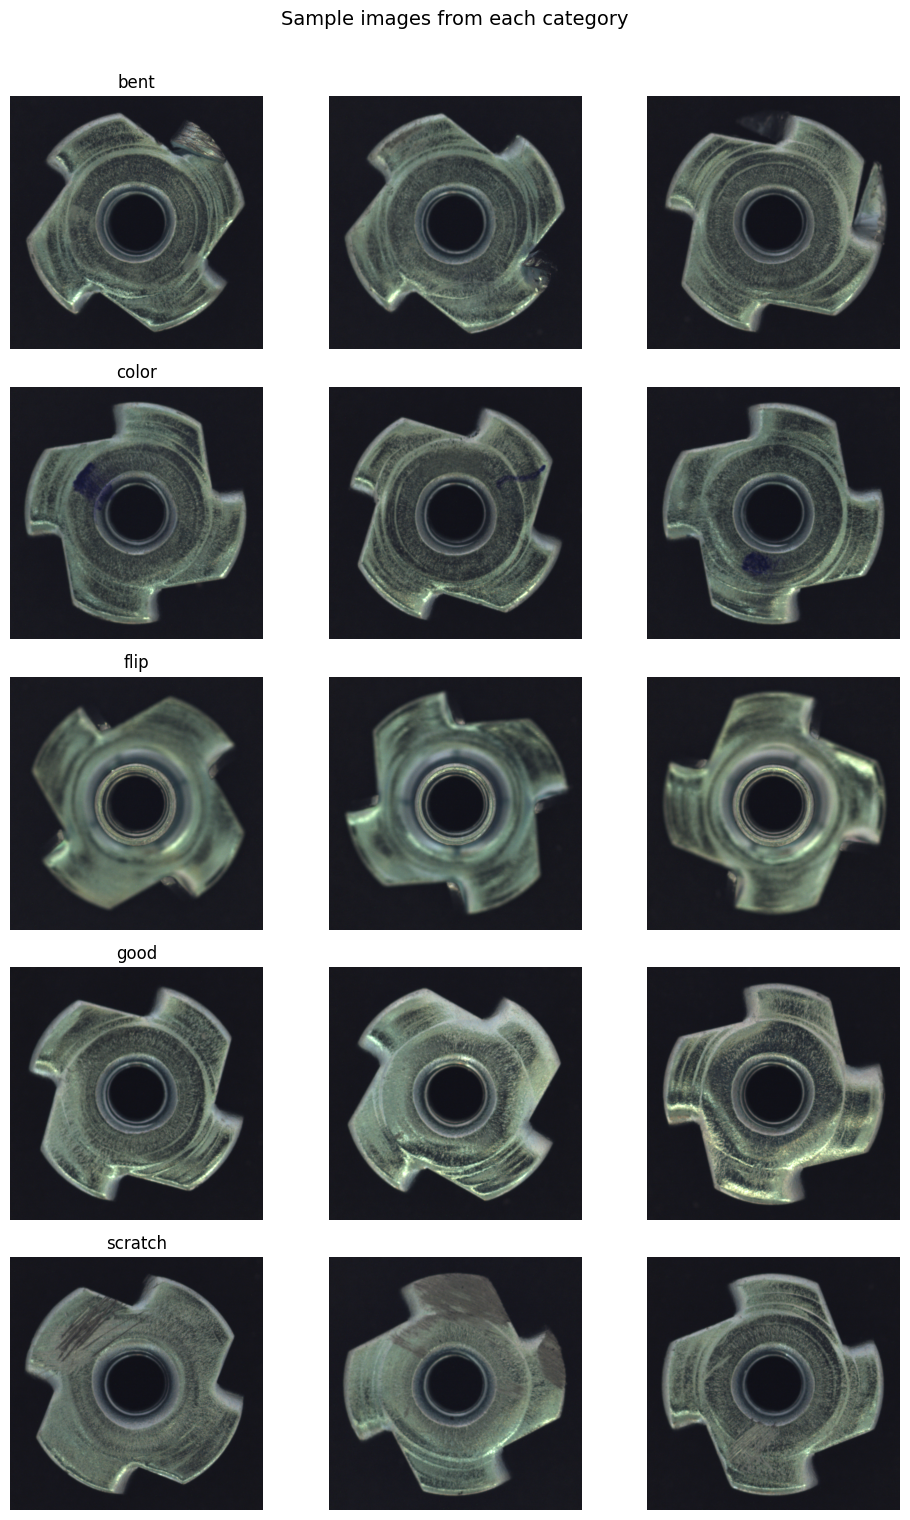

In [26]:
# show a few sample images from each class
unique_labels = sorted(set(true_labels))
fig, axes = plt.subplots(len(unique_labels), 3, figsize=(10, 3 * len(unique_labels)))

for row, label in enumerate(unique_labels):
    idxs = [i for i, l in enumerate(true_labels) if l == label]
    samples = np.random.choice(idxs, size=min(3, len(idxs)), replace=False)
    for col, idx in enumerate(samples):
        img = Image.open(image_paths[idx])
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        if col == 0:
            axes[row, col].set_title(label, fontsize=12)

plt.suptitle('Sample images from each category', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

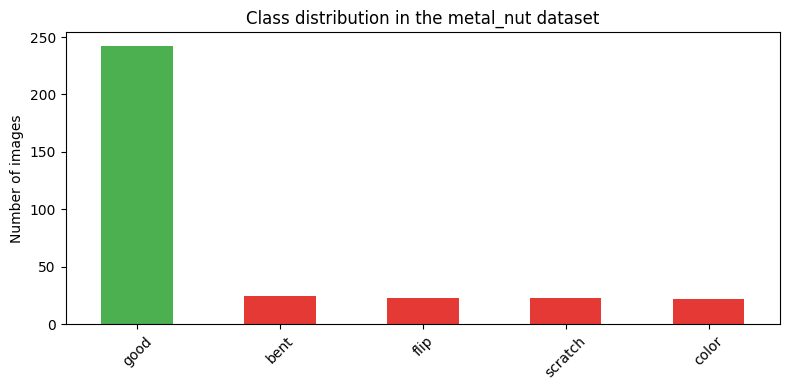

In [27]:
# class distribution as a bar chart
label_counts = pd.Series(true_labels).value_counts()
plt.figure(figsize=(8, 4))
label_counts.plot(kind='bar', color=['#4CAF50' if l == 'good' else '#E53935' for l in label_counts.index])
plt.ylabel('Number of images')
plt.title('Class distribution in the metal_nut dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The dataset is heavily imbalanced — there are far more "good" images than any single defect type. This actually makes sense for a real manufacturing scenario: most products coming off the line are fine, and defects are relatively rare. The question is whether clustering can still pick up on the defective ones despite being outnumbered.

## Feature Extraction with VGG16

We can't just feed raw pixel values into a clustering algorithm — the images are 224x224x3 which means ~150k dimensions per image, and most of that is noise (background, lighting, etc). Instead, we use a pretrained VGG16 model (without the classification head) to extract meaningful features. The model was trained on ImageNet so it already knows how to pick up on textures, edges, and shapes. With `pooling='avg'` we get a compact 512-dimensional feature vector per image.

In [28]:
base_model = VGG16(weights='imagenet', include_top=False, 
                   input_shape=(224, 224, 3), pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

print(f"Output feature dimension: {feature_extractor.output_shape[1]}")

Output feature dimension: 512


In [29]:
def extract_features(paths, model, img_size=(224, 224), batch_size=32):
    features = []
    total = len(paths)
    
    for i in range(0, total, batch_size):
        batch_paths = paths[i:i+batch_size]
        batch_images = []
        
        for p in batch_paths:
            img = load_img(p, target_size=img_size)
            arr = img_to_array(img)
            arr = preprocess_input(arr)
            batch_images.append(arr)
        
        batch_array = np.array(batch_images)
        batch_feats = model.predict(batch_array, verbose=0)
        features.extend(batch_feats)
        
        print(f"  Processed {min(i+batch_size, total)}/{total}", end='\r')
    
    print(f"  Done — extracted features for {total} images.")
    return np.array(features)

X_features = extract_features(image_paths, feature_extractor, IMG_SIZE)
print(f"Feature matrix shape: {X_features.shape}")

  Done — extracted features for 335 images.
Feature matrix shape: (335, 512)


In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)
print(f"Scaled features — mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")

Scaled features — mean: 0.0000, std: 0.9931


## PCA for Dimensionality Reduction

Even 512 dimensions is quite high for clustering. Let's use PCA to see how many components we actually need to retain most of the variance, and then reduce accordingly.

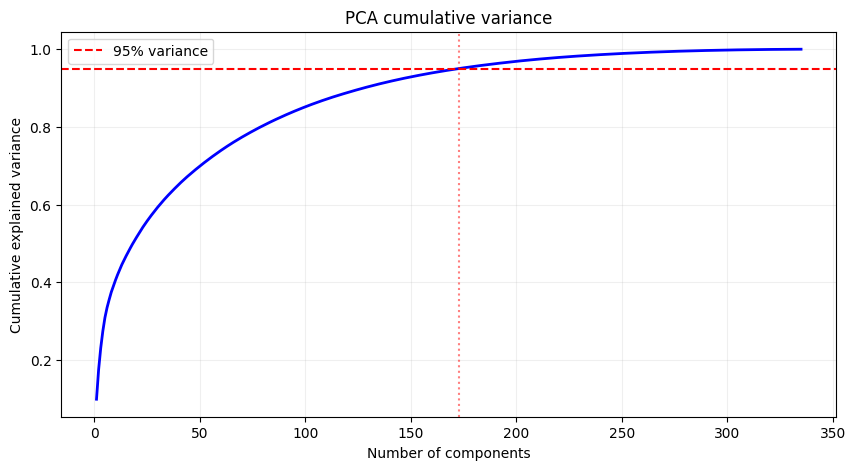

Components needed for 95% variance: 173


In [31]:
pca_full = PCA()
pca_full.fit(X_scaled)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_95 = np.argmax(cumsum >= 0.95) + 1

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum)+1), cumsum, 'b-', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=n_95, color='r', linestyle=':', alpha=0.5)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA cumulative variance')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

print(f"Components needed for 95% variance: {n_95}")

The PCA curve shows that 95% variance needs around 173 components — that's a lot. The curve rises steeply in the first 20-30 components and then gradually flattens. We chose to keep 50 components which retains about 69.7% of the variance. That's a trade-off: we're losing about 30% of the information, but going from 512 to 50 dimensions makes the clustering much more tractable. In practice the most discriminative features (edges, textures, shape anomalies) tend to be captured in the top components anyway, so 50 should be enough for the clustering to find meaningful structure.

In [32]:
# We deliberately choose 50 components rather than 173 (the 95% variance threshold)
# because clustering works better in lower dimensions — the curse of dimensionality
# means that distance-based algorithms degrade with too many features.
N_COMPONENTS = min(50, n_95)
pca = PCA(n_components=N_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)
print(f"Reduced: {X_scaled.shape[1]} -> {X_pca.shape[1]} dimensions")
print(f"Variance retained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

Reduced: 512 -> 50 dimensions
Variance retained: 69.7%


## K-means Clustering

### Finding the right number of clusters (k)

We don't know how many natural groups exist in the data, so we run K-means for k=2 to 14 and look at two things:
- **Elbow method**: plot inertia (within-cluster sum of squares) vs k. We look for the "elbow" where adding more clusters stops giving big improvements.
- **Silhouette score**: measures how well-separated the clusters are. Higher is better — we pick the k with the highest silhouette.

In [33]:
K_range = range(2, 15)
inertias = []
silhouette_scores_km = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_pca, km.labels_)
    silhouette_scores_km.append(sil)
    print(f"  k={k:2d}  inertia={km.inertia_:,.0f}  silhouette={sil:.4f}")

  k= 2  inertia=104,364  silhouette=0.1250
  k= 3  inertia=95,282  silhouette=0.1501
  k= 4  inertia=88,011  silhouette=0.1265
  k= 5  inertia=83,702  silhouette=0.1295
  k= 6  inertia=80,873  silhouette=0.1195
  k= 7  inertia=78,089  silhouette=0.1119
  k= 8  inertia=76,238  silhouette=0.1048
  k= 9  inertia=73,717  silhouette=0.0995
  k=10  inertia=72,454  silhouette=0.1003
  k=11  inertia=71,576  silhouette=0.1009
  k=12  inertia=69,292  silhouette=0.1032
  k=13  inertia=68,622  silhouette=0.1032
  k=14  inertia=66,603  silhouette=0.1018


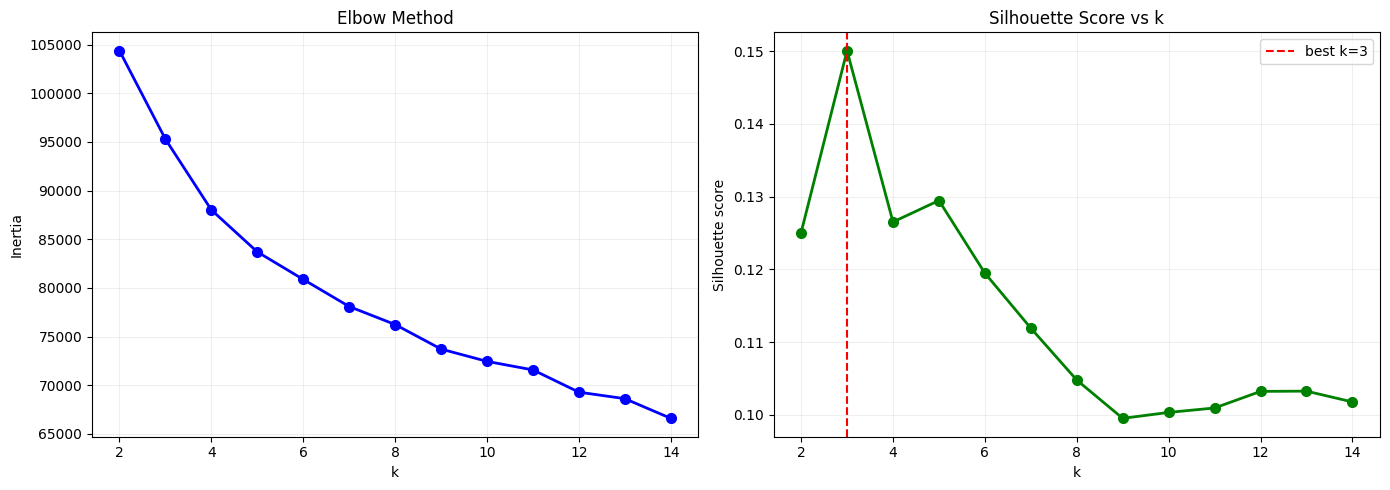

Best k by silhouette: 3 (score: 0.1501)


In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=7)
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.2)

ax2.plot(K_range, silhouette_scores_km, 'go-', linewidth=2, markersize=7)
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette Score vs k')
ax2.grid(True, alpha=0.2)

best_k = list(K_range)[np.argmax(silhouette_scores_km)]
ax2.axvline(x=best_k, color='r', linestyle='--', label=f'best k={best_k}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Best k by silhouette: {best_k} (score: {max(silhouette_scores_km):.4f})")

**Reading these plots:**

The **elbow plot** (left) shows inertia decreasing as we add more clusters. There's no dramatic elbow — the curve goes down fairly smoothly, which suggests the data doesn't have super obvious, well-separated groups. That said, the rate of decrease does slow down after about k=3-4.

The **silhouette plot** (right) is more informative. It peaks at k=3 with a score of 0.1501. Honestly, that's a pretty low silhouette score — anything below 0.25 means the clusters are weak and overlapping. This tells us that K-means is struggling to find well-separated groups, which makes sense because defective metal nuts can look quite similar to good ones.

We go with k=3 since that's the best we can get. It's interesting that it's 3 rather than 5 (we have 5 true categories) — this suggests that some defect types are too similar to each other and to the good images to be separated by K-means.

In [35]:
OPTIMAL_K = best_k
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_pca)

print(f"K-means with k={OPTIMAL_K}")
print(f"  Silhouette score:     {silhouette_score(X_pca, kmeans_labels):.4f}")
print(f"  Calinski-Harabasz:    {calinski_harabasz_score(X_pca, kmeans_labels):.2f}")
print(f"  Davies-Bouldin:       {davies_bouldin_score(X_pca, kmeans_labels):.4f}")

print(f"\nCluster sizes:")
for c, cnt in pd.Series(kmeans_labels).value_counts().sort_index().items():
    print(f"  Cluster {c}: {cnt} samples")

K-means with k=3
  Silhouette score:     0.1501
  Calinski-Harabasz:    39.50
  Davies-Bouldin:       2.1168

Cluster sizes:
  Cluster 0: 150 samples
  Cluster 1: 23 samples
  Cluster 2: 162 samples


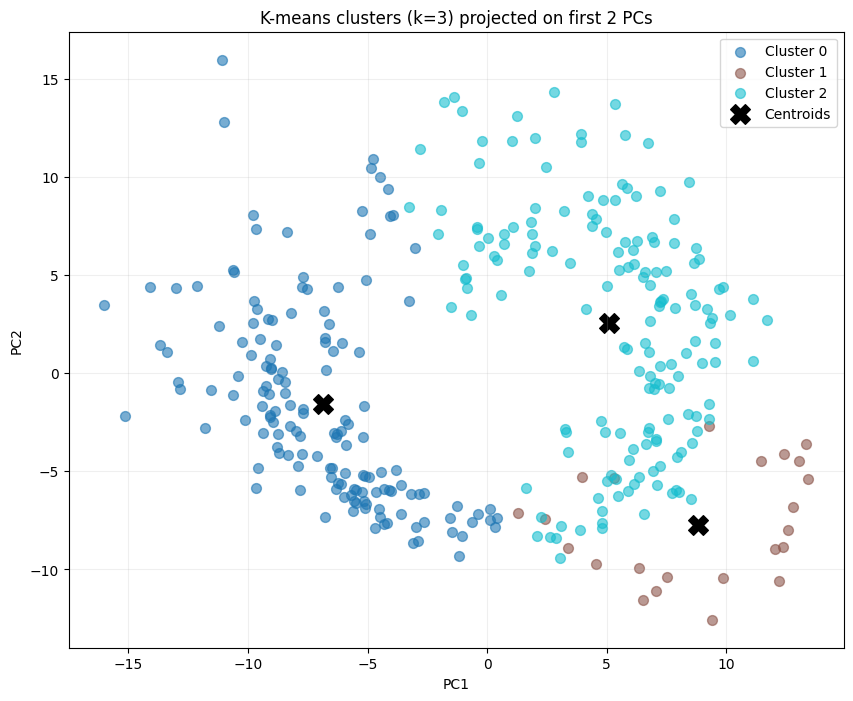

In [36]:
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, OPTIMAL_K))

for i in range(OPTIMAL_K):
    mask = kmeans_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], 
               label=f'Cluster {i}', alpha=0.6, s=50)

plt.scatter(kmeans_final.cluster_centers_[:, 0], 
           kmeans_final.cluster_centers_[:, 1], 
           c='black', marker='X', s=200, label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-means clusters (k={OPTIMAL_K}) projected on first 2 PCs')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

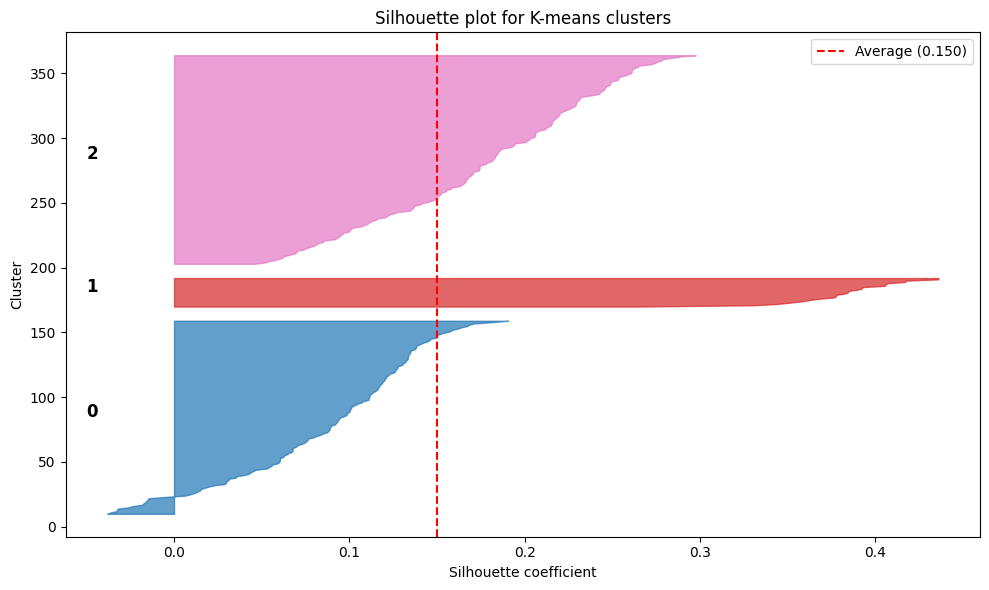

In [37]:
# silhouette analysis for each cluster — shows how well each sample fits
sample_sil_values = silhouette_samples(X_pca, kmeans_labels)

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

for i in range(OPTIMAL_K):
    cluster_sil = sample_sil_values[kmeans_labels == i]
    cluster_sil.sort()
    size = len(cluster_sil)
    y_upper = y_lower + size
    
    color = plt.cm.tab10(i / OPTIMAL_K)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                     facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size, str(i), fontsize=12, fontweight='bold')
    y_lower = y_upper + 10

ax.axvline(x=silhouette_score(X_pca, kmeans_labels), color='red', linestyle='--', 
           label=f'Average ({silhouette_score(X_pca, kmeans_labels):.3f})')
ax.set_xlabel('Silhouette coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette plot for K-means clusters')
ax.legend()
plt.tight_layout()
plt.show()

The silhouette plot shows the coefficient for every individual sample, grouped by cluster. A well-formed cluster should have most of its samples with positive silhouette values and no large portion below zero. Here, all three clusters have a mix of positive and negative values — particularly clusters 0 and 2, which have many samples near or below zero. Cluster 1 (the small one with 23 flip images) has the strongest silhouette values, confirming it's the most internally cohesive and well-separated group. The red dashed line marks the overall average — at 0.15, it's quite low, meaning the clustering structure is weak overall.

The scatter plot confirms what the low silhouette score hinted at — the clusters overlap quite a bit when projected onto the first two principal components. Cluster 0 has 150 samples, cluster 1 has only 23, and cluster 2 has 162. The small cluster 1 is the most distinct and well-separated, while clusters 0 and 2 are large and seem to overlap. We'll check later what's actually in each cluster.

## DBSCAN Clustering

### Estimating eps with k-NN distances

DBSCAN needs two hyperparameters: `eps` (neighborhood radius) and `min_samples` (minimum points to form a dense region). To get a good starting point for eps, we compute the k-nearest-neighbor distance for every point and sort them. The "knee" in this curve suggests a natural eps value.

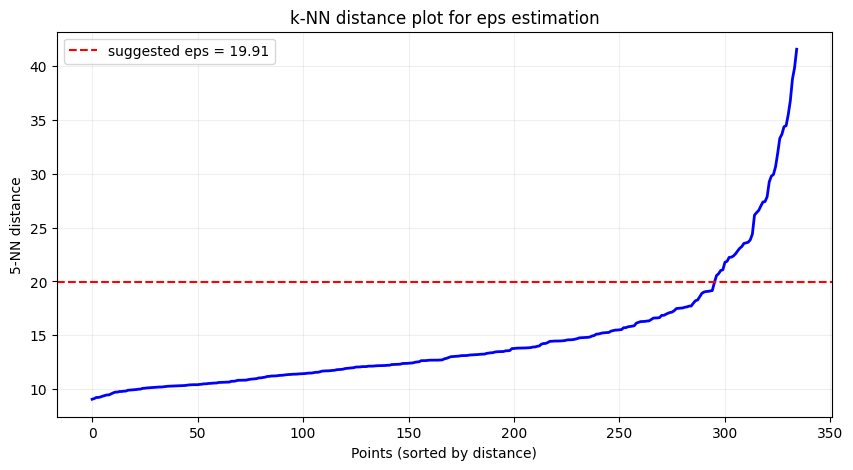

Suggested eps from k-NN curve: 19.9086


In [38]:
k_neighbors = 5
nn = NearestNeighbors(n_neighbors=k_neighbors)
nn.fit(X_pca)
distances, _ = nn.kneighbors(X_pca)
k_distances = np.sort(distances[:, k_neighbors-1])

plt.figure(figsize=(10, 5))
plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{k_neighbors}-NN distance')
plt.title('k-NN distance plot for eps estimation')
plt.grid(True, alpha=0.2)

# find the knee automatically
gradient = np.gradient(k_distances)
elbow_idx = np.argmax(gradient > np.mean(gradient) + 2*np.std(gradient))
suggested_eps = k_distances[elbow_idx]
plt.axhline(y=suggested_eps, color='r', linestyle='--', label=f'suggested eps = {suggested_eps:.2f}')
plt.legend()
plt.show()

print(f"Suggested eps from k-NN curve: {suggested_eps:.4f}")

The k-NN distance curve is relatively smooth with a sharp uptick at the far right for outlier points. The knee was detected at around eps=19.91, which is the suggested distance threshold. However, this is just a starting point — since a small change in eps can radically change DBSCAN's output, we'll search around this value systematically with a grid search.

### Grid Search over eps and min_samples

Rather than just using the suggested eps, we try a range of eps values (from 50% to 200% of the suggestion) combined with different min_samples values. We pick the combination that gives the best silhouette score while still producing at least 2 clusters.

In [39]:
eps_range = np.linspace(max(0.5, suggested_eps*0.5), suggested_eps*2, 10)
min_samples_range = [3, 5, 7, 10, 15]

results = []
for eps in eps_range:
    for ms in min_samples_range:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters >= 2:
            mask = labels != -1
            if sum(mask) > n_clusters:
                sil = silhouette_score(X_pca[mask], labels[mask])
            else:
                sil = -1
        else:
            sil = -1
        
        results.append({'eps': round(eps, 3), 'min_samples': ms, 
                       'n_clusters': n_clusters, 'n_noise': n_noise, 
                       'silhouette': round(sil, 4)})

df_results = pd.DataFrame(results)
df_valid = df_results[(df_results['n_clusters'] >= 2) & (df_results['silhouette'] > 0)]

if len(df_valid) > 0:
    df_sorted = df_valid.sort_values('silhouette', ascending=False)
    print("Top 5 parameter combinations:")
    print(df_sorted.head(5).to_string(index=False))
    
    best = df_sorted.iloc[0]
    BEST_EPS = best['eps']
    BEST_MIN_SAMPLES = int(best['min_samples'])
else:
    print("No valid combinations found, falling back to suggested eps")
    BEST_EPS = suggested_eps
    BEST_MIN_SAMPLES = 5

print(f"\nBest: eps={BEST_EPS:.4f}, min_samples={BEST_MIN_SAMPLES}")

Top 5 parameter combinations:
   eps  min_samples  n_clusters  n_noise  silhouette
13.272            7           2      129      0.3054
 9.954            5           6      274      0.2668
16.590           10           2       54      0.2634
16.590            7           2       48      0.2628
16.590            5           2       47      0.2622

Best: eps=13.2720, min_samples=7


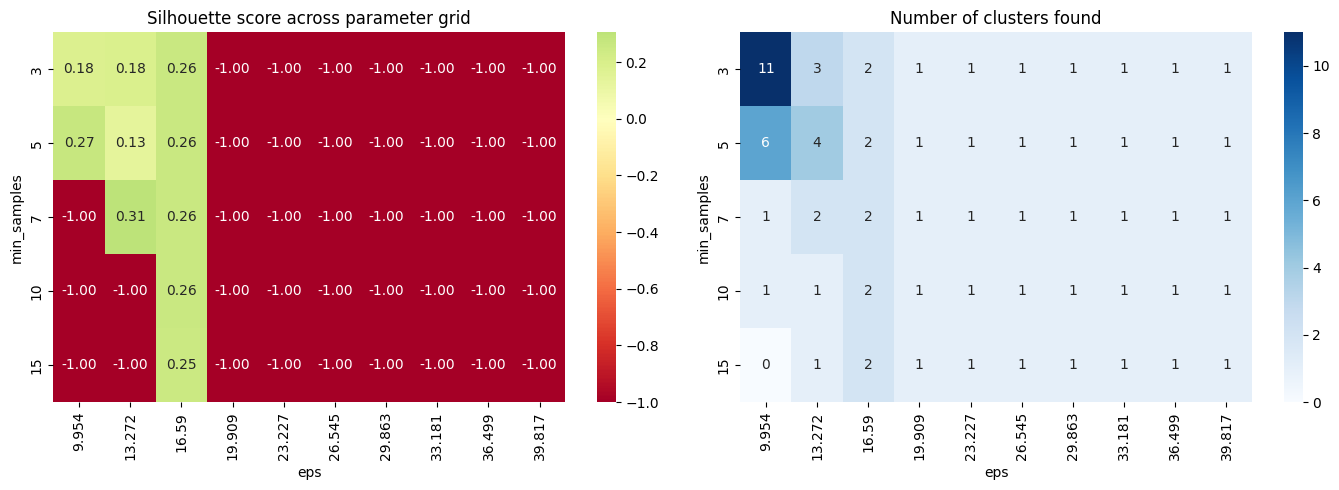

In [40]:
# heatmaps to visualize the grid search results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

pivot_sil = df_results.pivot_table(values='silhouette', index='min_samples', columns='eps')
sns.heatmap(pivot_sil, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax1, center=0)
ax1.set_title('Silhouette score across parameter grid')

pivot_n = df_results.pivot_table(values='n_clusters', index='min_samples', columns='eps')
sns.heatmap(pivot_n, annot=True, fmt='.0f', cmap='Blues', ax=ax2)
ax2.set_title('Number of clusters found')

plt.tight_layout()
plt.show()

**Reading the heatmaps:**

The **silhouette heatmap** (left) shows that most parameter combinations produce either -1 (degenerate clustering, only 1 or 0 clusters) or very low positive values. The best silhouette score of 0.31 appears at eps=13.27, min_samples=7 — which is actually well below our initial eps suggestion. This makes sense because a smaller eps creates tighter clusters.

The **cluster count heatmap** (right) shows a clear pattern: at low eps DBSCAN finds many clusters (or marks most points as noise), and at high eps everything gets merged. With our best parameters (eps=13.27, min_samples=7) DBSCAN found only 2 clusters — significantly fewer than the 5 true categories. However, it also flagged 129 points (38.5%) as noise, which is actually interesting from a defect detection standpoint.

In [41]:
dbscan_final = DBSCAN(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES)
dbscan_labels = dbscan_final.fit_predict(X_pca)

n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_db = list(dbscan_labels).count(-1)

mask_valid = dbscan_labels != -1
if sum(mask_valid) > n_clusters_db and n_clusters_db >= 2:
    db_sil = silhouette_score(X_pca[mask_valid], dbscan_labels[mask_valid])
    db_ch = calinski_harabasz_score(X_pca[mask_valid], dbscan_labels[mask_valid])
    db_dbi = davies_bouldin_score(X_pca[mask_valid], dbscan_labels[mask_valid])
else:
    db_sil, db_ch, db_dbi = 0, 0, float('inf')

print(f"DBSCAN results (eps={BEST_EPS:.4f}, min_samples={BEST_MIN_SAMPLES}):")
print(f"  Clusters found:       {n_clusters_db}")
print(f"  Noise points:         {n_noise_db} ({n_noise_db/len(dbscan_labels)*100:.1f}%)")
print(f"  Silhouette score:     {db_sil:.4f}")
print(f"  Calinski-Harabasz:    {db_ch:.2f}")
print(f"  Davies-Bouldin:       {db_dbi:.4f}")

print(f"\nCluster sizes:")
for c, cnt in pd.Series(dbscan_labels).value_counts().sort_index().items():
    name = 'Noise' if c == -1 else f'Cluster {c}'
    print(f"  {name}: {cnt} samples")

DBSCAN results (eps=13.2720, min_samples=7):
  Clusters found:       2
  Noise points:         129 (38.5%)
  Silhouette score:     0.3054
  Calinski-Harabasz:    31.61
  Davies-Bouldin:       1.1249

Cluster sizes:
  Noise: 129 samples
  Cluster 0: 192 samples
  Cluster 1: 14 samples


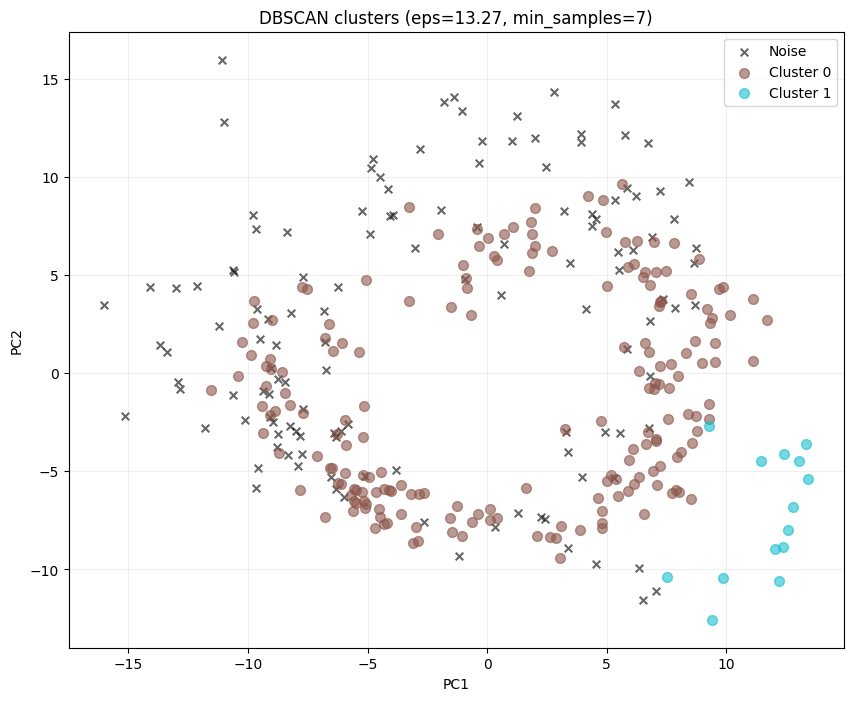

In [42]:
plt.figure(figsize=(10, 8))
unique_labs = sorted(set(dbscan_labels))
colors_db = plt.cm.tab10(np.linspace(0, 1, len(unique_labs)))

for k, col in zip(unique_labs, colors_db):
    if k == -1:
        col = [0, 0, 0, 1]
        label = 'Noise'
        marker = 'x'
        s = 30
    else:
        label = f'Cluster {k}'
        marker = 'o'
        s = 50
    mask = dbscan_labels == k
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[col], 
               label=label, marker=marker, s=s, alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'DBSCAN clusters (eps={BEST_EPS:.2f}, min_samples={BEST_MIN_SAMPLES})')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

The DBSCAN scatter plot shows a very different picture from K-means. The main cluster (Cluster 0, 192 samples) forms the dense core, and a small separate cluster (Cluster 1, just 14 samples) stands apart. The rest — 129 samples — are marked as noise (black x markers).

The fact that 38.5% of points are noise is actually quite telling. DBSCAN is essentially saying: there's one big dense group, one small distinct group, and a lot of points that don't fit cleanly into either. For anomaly detection this is useful — those noise points could include our defective products.

## t-SNE Visualization

t-SNE gives us a better 2D view of the data compared to just plotting the first two PCs. It tries to preserve local neighborhoods, so points that are close in the 50-dimensional PCA space should also appear close in the 2D plot. This will help us see whether the clusters from K-means and DBSCAN actually correspond to meaningful groups.

In [43]:
print("Running t-SNE (this might take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)
print("Done.")

Running t-SNE (this might take a minute)...
Done.


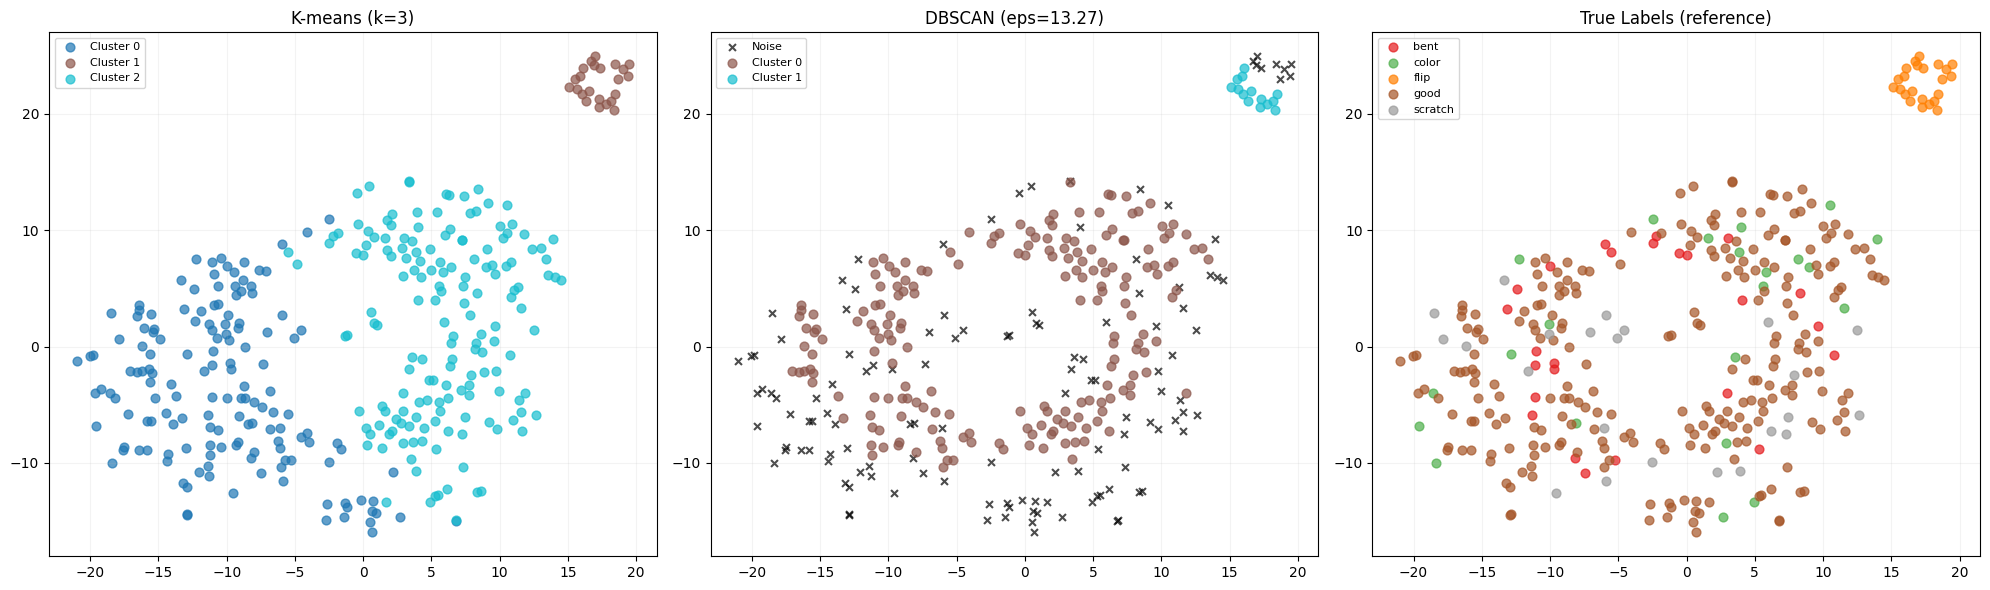

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-means labels on t-SNE
colors_km = plt.cm.tab10(np.linspace(0, 1, OPTIMAL_K))
for i in range(OPTIMAL_K):
    mask = kmeans_labels == i
    axes[0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[colors_km[i]], 
                   label=f'Cluster {i}', alpha=0.7, s=40)
axes[0].set_title(f'K-means (k={OPTIMAL_K})')
axes[0].legend(fontsize=8)

# DBSCAN labels on t-SNE
db_colors = plt.cm.tab10(np.linspace(0, 1, len(set(dbscan_labels))))
for k, col in zip(sorted(set(dbscan_labels)), db_colors):
    if k == -1:
        col = [0, 0, 0, 1]
        label = 'Noise'
        marker = 'x'
        s = 25
    else:
        label = f'Cluster {k}'
        marker = 'o'
        s = 40
    mask = dbscan_labels == k
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[col], 
                   label=label, marker=marker, s=s, alpha=0.7)
axes[1].set_title(f'DBSCAN (eps={BEST_EPS:.2f})')
axes[1].legend(fontsize=8)

# True labels on t-SNE
unique_true = sorted(set(true_labels))
colors_true = plt.cm.Set1(np.linspace(0, 1, len(unique_true)))
for i, label in enumerate(unique_true):
    mask = np.array(true_labels) == label
    axes[2].scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[colors_true[i]], 
                   label=label, alpha=0.7, s=40)
axes[2].set_title('True Labels (reference)')
axes[2].legend(fontsize=8)

for ax in axes:
    ax.grid(True, alpha=0.15)

plt.tight_layout()
plt.show()

**Interpreting the t-SNE plots:**

The three side-by-side views are very revealing:

In the **true labels plot** (right), we can see that 'good' images (the dominant class) form a large main group, but some defect types — particularly 'flip' — form a clearly separate cluster. Other defect types like 'scratch', 'color', and 'bent' overlap heavily with the good images, making them hard to separate by any unsupervised method.

The **K-means plot** (left) with k=3 splits the data into three roughly equal-sized chunks. Notably, it does manage to isolate the flip defects into their own cluster (Cluster 1 with 23 samples = 100% flip). But the other two clusters both mix good images with other defect types, so K-means can't tell those apart.

The **DBSCAN plot** (middle) shows a similar pattern — Cluster 1 (14 samples) captures most of the flip defects, and Cluster 0 is dominated by good images. The noise points (black x markers scattered around) contain a mix of everything, but with a higher proportion of defects compared to the main cluster.

## Cluster Composition Analysis

Now let's look at what's actually inside each cluster. This is the key analysis — do the clusters correspond to defect types, or are they mixing everything together?

In [45]:
def analyze_clusters(cluster_labels, true_labels, method_name):
    """Print what each cluster contains in terms of true labels."""
    df = pd.DataFrame({'cluster': cluster_labels, 'true_label': true_labels})
    
    print(f"\n{method_name} — cluster composition:")
    print("-" * 45)
    
    for c in sorted(set(cluster_labels)):
        name = 'Noise' if c == -1 else f'Cluster {c}'
        subset = df[df['cluster'] == c]
        print(f"\n{name} ({len(subset)} samples):")
        for label, cnt in subset['true_label'].value_counts().items():
            pct = cnt / len(subset) * 100
            print(f"  {label:12s}: {cnt:4d}  ({pct:.1f}%)")

analyze_clusters(kmeans_labels, true_labels, 'K-MEANS')
analyze_clusters(dbscan_labels, true_labels, 'DBSCAN')


K-MEANS — cluster composition:
---------------------------------------------

Cluster 0 (150 samples):
  good        :  113  (75.3%)
  scratch     :   15  (10.0%)
  bent        :   13  (8.7%)
  color       :    9  (6.0%)

Cluster 1 (23 samples):
  flip        :   23  (100.0%)

Cluster 2 (162 samples):
  good        :  129  (79.6%)
  color       :   13  (8.0%)
  bent        :   12  (7.4%)
  scratch     :    8  (4.9%)

DBSCAN — cluster composition:
---------------------------------------------

Noise (129 samples):
  good        :   74  (57.4%)
  scratch     :   19  (14.7%)
  color       :   15  (11.6%)
  bent        :   12  (9.3%)
  flip        :    9  (7.0%)

Cluster 0 (192 samples):
  good        :  168  (87.5%)
  bent        :   13  (6.8%)
  color       :    7  (3.6%)
  scratch     :    4  (2.1%)

Cluster 1 (14 samples):
  flip        :   14  (100.0%)


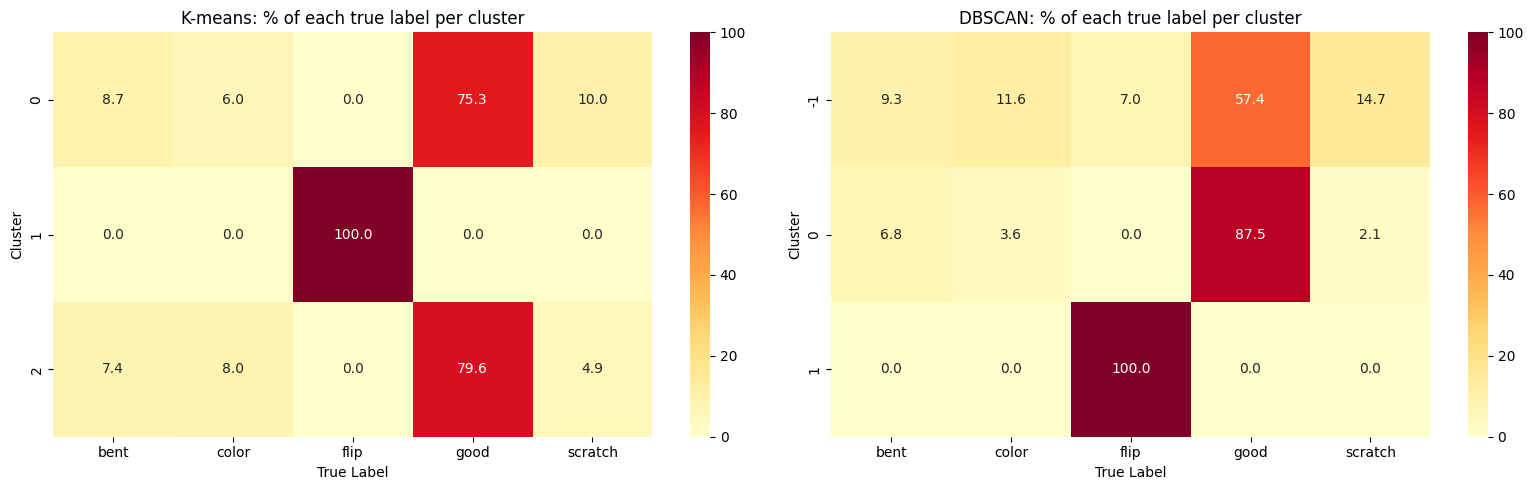

In [46]:
# cross-tabulation heatmaps for a visual view
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ct_km = pd.crosstab(pd.Series(kmeans_labels, name='Cluster'), 
                     pd.Series(true_labels, name='True Label'), 
                     normalize='index') * 100
sns.heatmap(ct_km, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax1)
ax1.set_title('K-means: % of each true label per cluster')

ct_db = pd.crosstab(pd.Series(dbscan_labels, name='Cluster'), 
                     pd.Series(true_labels, name='True Label'), 
                     normalize='index') * 100
sns.heatmap(ct_db, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
ax2.set_title('DBSCAN: % of each true label per cluster')

plt.tight_layout()
plt.show()

**What the composition analysis tells us:**

The cross-tabulation heatmaps make the story clear:

**K-means:** Cluster 1 is a clean win — it captured **all 23 flip images** and nothing else (100% purity). This is impressive. However, Clusters 0 and 2 are both mostly good images (75.3% and 79.6%) with defects like scratch, bent, and color sprinkled in. K-means couldn't separate those defect types from normal images.

**DBSCAN:** Cluster 1 similarly captured 14 flip images with 100% purity (though it missed 9 flips that ended up in noise). Cluster 0 is 87.5% good images — a higher purity than K-means' clusters, meaning it's better at defining what "normal" looks like. The noise category contains 57.4% good images and 42.6% defects. While that's not perfect, defective images are disproportionately represented in the noise (defects make up only 27.8% of total data but 42.6% of the noise).

**Key takeaway:** Both algorithms successfully separate 'flip' defects — those are visually distinct (the nut is flipped upside down). But 'scratch', 'color', and 'bent' defects are too subtle for either algorithm to isolate with unsupervised clustering alone. For detecting these subtle defects, a supervised or semi-supervised approach would be needed.

## Final Comparison: K-means vs DBSCAN for Defect Detection

In [47]:
km_sil = silhouette_score(X_pca, kmeans_labels)
km_ch = calinski_harabasz_score(X_pca, kmeans_labels)
km_dbi = davies_bouldin_score(X_pca, kmeans_labels)

comparison = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin', 
               'Clusters Found', 'Noise Points', 'Hyperparameter Method'],
    'K-means': [f'{km_sil:.4f}', f'{km_ch:.2f}', f'{km_dbi:.4f}', 
                str(OPTIMAL_K), '0 (assigns all)', 'Elbow + Silhouette'],
    'DBSCAN': [f'{db_sil:.4f}', f'{db_ch:.2f}', f'{db_dbi:.4f}', 
               str(n_clusters_db), f'{n_noise_db} ({n_noise_db/len(dbscan_labels)*100:.1f}%)', 'Grid Search']
})

print(comparison.to_string(index=False))

               Metric            K-means      DBSCAN
     Silhouette Score             0.1501      0.3054
    Calinski-Harabasz              39.50       31.61
       Davies-Bouldin             2.1168      1.1249
       Clusters Found                  3           2
         Noise Points    0 (assigns all) 129 (38.5%)
Hyperparameter Method Elbow + Silhouette Grid Search


## Conclusion

### Results summary

We tested two unsupervised clustering algorithms on VGG16 features extracted from 335 metal nut images (242 good + 93 defective across 4 defect types).

| Metric | K-means (k=3) | DBSCAN (eps=13.27, min_samples=7) |
| --- | --- | --- |
| Silhouette Score | 0.1501 | 0.3054 |
| Calinski-Harabasz | 39.50 | 31.61 |
| Davies-Bouldin | 2.1168 | 1.1249 |
| Clusters found | 3 | 2 |
| Noise / unassigned | 0 | 129 (38.5%) |

DBSCAN has the higher silhouette score (0.31 vs 0.15) and a much better Davies-Bouldin index (1.12 vs 2.12 — lower is better). K-means wins on Calinski-Harabasz (39.5 vs 31.6), but that metric is inflated by the fact that K-means assigns every point and uses more clusters.

### Which algorithm is better for defect detection?

For this manufacturing use case, **DBSCAN is the more practical choice**, and here's why:

1. **Anomaly detection by design.** DBSCAN's noise category acts as a natural anomaly detector. In our results, 42.6% of noise points were defective, even though defects make up only 27.8% of the total dataset. This means a simple "flag everything DBSCAN calls noise" rule would catch defects at a higher-than-baseline rate.

2. **Higher purity for the 'normal' cluster.** DBSCAN's main cluster (Cluster 0) is 87.5% good images, compared to K-means where both large clusters mix 20-25% defects. If we wanted to define what a "normal" metal nut looks like, DBSCAN gives us a cleaner reference.

3. **K-means' limitation.** K-means forces every image into a cluster, even if it doesn't belong. Defective images get absorbed into the nearest cluster and become invisible. DBSCAN explicitly flags them as "doesn't fit."

4. **Both detect 'flip' defects.** K-means Cluster 1 (23 samples, 100% flip) and DBSCAN Cluster 1 (14 samples, 100% flip) both successfully isolated the flip defect type — it's visually distinct enough for unsupervised methods to catch.

5. **Neither handles subtle defects.** Scratch, color, and bent defects are too visually similar to good images in the VGG16 feature space. Both algorithms mixed these with good images — this is a fundamental limitation of unsupervised clustering for subtle manufacturing defects.

### What this means for a production system

In a real production line, we could use DBSCAN as a **first-pass anomaly filter**: any metal nut image that falls outside the dense "good" cluster gets flagged for human review. This wouldn't catch every defect (we'd miss subtle scratches and color variations), but it would catch the obvious ones (flipped nuts and severely bent ones) with zero labeled training data.

To improve detection of subtle defects, we'd need to move beyond pure unsupervised clustering:

### Future directions

- **One-class classification** (e.g., Isolation Forest, One-Class SVM): train only on "good" images and flag anything that deviates. This is the standard approach in industrial anomaly detection.
- **Fine-tuned feature extraction**: instead of off-the-shelf VGG16, fine-tune a CNN on this specific product category to learn features that are more sensitive to metal nut defects.
- **Supervised classification**: with the labeled data we have (good vs. 4 defect types), a supervised CNN classifier would far outperform unsupervised clustering. Clustering is most valuable when labels are expensive or unavailable.
- **Autoencoder-based detection**: train an autoencoder on only good images. Defective images would have higher reconstruction error, making them easy to flag.
- **Hybrid approach**: use DBSCAN as a pre-filter to catch obvious anomalies, then pass uncertain cases to a supervised model for finer classification.

## References

- Bergmann, P., Fauser, M., Sattlegger, D., & Steger, C. (2019). *MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection.* IEEE/CVF CVPR.
- Simonyan, K., & Zisserman, A. (2015). *Very Deep Convolutional Networks for Large-Scale Image Recognition* (VGG16). ICLR 2015.
- Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). *A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise* (DBSCAN). KDD.
- MacQueen, J. (1967). *Some Methods for Classification and Analysis of Multivariate Observations* (K-means). Proc. 5th Berkeley Symp.
- van der Maaten, L., & Hinton, G. (2008). *Visualizing Data using t-SNE.* JMLR, 9, 2579-2605.